In [ ]:
_EPSILON = 1e-08

import numpy as np
import pandas as pd
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# import sys

from termcolor import colored
from tensorflow.contrib.layers import fully_connected as FC_Net
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

import import_data as impt
import utils_network as utils

from class_DeepHit import Model_DeepHit
from utils_eval import c_index, brier_score, weighted_c_index, weighted_brier_score


def load_logging(filename):
    data = dict()
    with open(filename) as f:
        def is_float(input):
            try:
                num = float(input)
            except ValueError:
                return False
            return True

        for line in f.readlines():
            if ':' in line:
                key,value = line.strip().split(':', 1)
                if value.isdigit():
                    data[key] = int(value)
                elif is_float(value):
                    data[key] = float(value)
                elif value == 'None':
                    data[key] = None
                else:
                    data[key] = value
            else:
                pass # deal with bad lines of text here    
    return data



##### MAIN SETTING
OUT_ITERATION               = 5

data_mode                   = 'GPU' #METABRIC, SYNTHETIC
seed                        =  1234

EVAL_TIMES                  = [12, 24, 36] # evalution times (for C-index and Brier-Score)


##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2 (to make enough time horizon)
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (num_features)
    mask1, mask2            = used for cause-specific network (FCNet structure)
'''
if data_mode == 'SYNTHETIC':
    (x_dim), (data, time, label), (mask1, mask2) = impt.import_dataset_SYNTHETIC(norm_mode = 'standard')
    percentiles = np.linspace(2, 100, 20)  # Adjust as needed
    EVAL_TIMES = np.percentile(time.flatten(),percentiles)
elif data_mode == 'METABRIC':
    (x_dim), (data, time, label), (mask1, mask2) = impt.import_dataset_METABRIC(norm_mode = 'standard')
    percentiles = np.linspace(2, 100, 20)  # Adjust as needed
    EVAL_TIMES = np.percentile(time.flatten(),percentiles)
elif data_mode == 'SEER':
    (x_dim), (data, time, label), (mask1, mask2) = impt.import_dataset_SEER(norm_mode = 'standard')
    percentiles = np.linspace(2, 100, 20)  # Adjust as needed
    EVAL_TIMES = np.percentile(time.flatten(),percentiles)
elif data_mode == 'GPU':
    (x_dim), (data, time, label), (mask1, mask2) = impt.import_dataset_GPU(norm_mode = "standard")
    percentiles = np.linspace(2, 100, 20)  # Adjust as needed
    EVAL_TIMES = np.percentile(time.flatten(),percentiles)
else:
    print('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask1: [subj, Num_Event, Num_Category]



in_path = data_mode + '/results/'

if not os.path.exists(in_path):
    os.makedirs(in_path)


FINAL1 = np.zeros([num_Event, len(EVAL_TIMES), OUT_ITERATION])
FINAL2 = np.zeros([num_Event, len(EVAL_TIMES), OUT_ITERATION])


for out_itr in range(OUT_ITERATION):
    in_hypfile = in_path + '/itr_' + str(out_itr) + '/hyperparameters_log.txt'
    in_parser = load_logging(in_hypfile)


    ##### HYPER-PARAMETERS
    mb_size                     = in_parser['mb_size']

    iteration                   = in_parser['iteration']

    keep_prob                   = in_parser['keep_prob']
    lr_train                    = in_parser['lr_train']

    h_dim_shared                = in_parser['h_dim_shared']
    h_dim_CS                    = in_parser['h_dim_CS']
    num_layers_shared           = in_parser['num_layers_shared']
    num_layers_CS               = in_parser['num_layers_CS']

    if in_parser['active_fn'] == 'relu':
        active_fn                = tf.nn.relu
    elif in_parser['active_fn'] == 'elu':
        active_fn                = tf.nn.elu
    elif in_parser['active_fn'] == 'tanh':
        active_fn                = tf.nn.tanh
    else:
        print('Error!')


    initial_W                   = tf.contrib.layers.xavier_initializer()

    alpha                       = in_parser['alpha']  #for log-likelihood loss
    beta                        = in_parser['beta']  #for ranking loss
    gamma                       = in_parser['gamma']  #for RNN-prediction loss
    parameter_name              = 'a' + str('%02.0f' %(10*alpha)) + 'b' + str('%02.0f' %(10*beta)) + 'c' + str('%02.0f' %(10*gamma))


    ##### MAKE DICTIONARIES
    # INPUT DIMENSIONS
    input_dims                  = { 'x_dim'         : x_dim,
                                    'num_Event'     : num_Event,
                                    'num_Category'  : num_Category}

    # NETWORK HYPER-PARMETERS
    network_settings            = { 'h_dim_shared'         : h_dim_shared,
                                    'h_dim_CS'          : h_dim_CS,
                                    'num_layers_shared'    : num_layers_shared,
                                    'num_layers_CS'    : num_layers_CS,
                                    'active_fn'      : active_fn,
                                    'initial_W'         : initial_W }


    # for out_itr in range(OUT_ITERATION):
    print ('ITR: ' + str(out_itr+1) + ' DATA MODE: ' + data_mode + ' (a:' + str(alpha) + ' b:' + str(beta) + ' c:' + str(gamma) + ')' )
    ##### CREATE DEEPFHT NETWORK
    tf.reset_default_graph()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)

    model = Model_DeepHit(sess, "DeepHit", input_dims, network_settings)
    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())

    ### TRAINING-TESTING SPLIT
    (tr_data,te_data, tr_time,te_time, tr_label,te_label, 
     tr_mask1,te_mask1, tr_mask2,te_mask2)  = train_test_split(data, time, label, mask1, mask2, test_size=0.20, random_state=seed) 

    (tr_data,va_data, tr_time,va_time, tr_label,va_label, 
     tr_mask1,va_mask1, tr_mask2,va_mask2)  = train_test_split(tr_data, tr_time, tr_label, tr_mask1, tr_mask2, test_size=0.20, random_state=seed) 
    
    ##### PREDICTION & EVALUATION
    saver.restore(sess, in_path + '/itr_' + str(out_itr) + '/models/model_itr_' + str(out_itr))

    ### PREDICTION
    pred = model.predict(te_data)
    
    ### EVALUATION
    result1, result2 = np.zeros([num_Event, len(EVAL_TIMES)]), np.zeros([num_Event, len(EVAL_TIMES)])

    for t, t_time in enumerate(EVAL_TIMES):
        eval_horizon = int(t_time)

        if eval_horizon >= num_Category:
            print( 'ERROR: evaluation horizon is out of range')
            result1[:, t] = result2[:, t] = -1
        else:
            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,:(eval_horizon+1)], axis=2) #risk score until EVAL_TIMES
            for k in range(num_Event):
                # result1[k, t] = c_index(risk[:,k], te_time, (te_label[:,0] == k+1).astype(float), eval_horizon) #-1 for no event (not comparable)
                # result2[k, t] = brier_score(risk[:,k], te_time, (te_label[:,0] == k+1).astype(float), eval_horizon) #-1 for no event (not comparable)
                result1[k, t] = weighted_c_index(tr_time, (tr_label[:,0] == k+1).astype(int), risk[:,k], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                result2[k, t] = weighted_brier_score(tr_time, (tr_label[:,0] == k+1).astype(int), risk[:,k], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)

    FINAL1[:, :, out_itr] = result1
    FINAL2[:, :, out_itr] = result2

    ### SAVE RESULTS
    row_header = []
    for t in range(num_Event):
        row_header.append('Event_' + str(t+1))

    col_header1 = []
    col_header2 = []
    for t in EVAL_TIMES:
        col_header1.append(str(t) + 'yr c_index')
        col_header2.append(str(t) + 'yr B_score')

    # c-index result
    df1 = pd.DataFrame(result1, index = row_header, columns=col_header1)
    df1.to_csv(in_path + '/result_CINDEX_itr' + str(out_itr) + '.csv')

    # brier-score result
    df2 = pd.DataFrame(result2, index = row_header, columns=col_header2)
    df2.to_csv(in_path + '/result_BRIER_itr' + str(out_itr) + '.csv')

    ### PRINT RESULTS
    print('========================================================')
    print('ITR: ' + str(out_itr+1) + ' DATA MODE: ' + data_mode + ' (a:' + str(alpha) + ' b:' + str(beta) + ' c:' + str(gamma) + ')' )
    print('SharedNet Parameters: ' + 'h_dim_shared = '+str(h_dim_shared) + ' num_layers_shared = '+str(num_layers_shared) + 'Non-Linearity: ' + str(active_fn))
    print('CSNet Parameters: ' + 'h_dim_CS = '+str(h_dim_CS) + ' num_layers_CS = '+str(num_layers_CS) + 'Non-Linearity: ' + str(active_fn)) 

    print('--------------------------------------------------------')
    print('- C-INDEX: ')
    print(df1)
    print('--------------------------------------------------------')
    print('- BRIER-SCORE: ')
    print(df2)
    print('========================================================')


ITR: 1 DATA MODE: SYNTHETIC (a:1.0 b:1.0 c:0)
INFO:tensorflow:Restoring parameters from SYNTHETIC/results//itr_0/models/model_itr_0


INFO:tensorflow:Restoring parameters from SYNTHETIC/results//itr_0/models/model_itr_0


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

2 root error(s) found.
  (0) Not found: Key DeepHit/DeepHit/fully_connected_5/biases/Adam not found in checkpoint
	 [[node save/RestoreV2 (defined at home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
  (1) Not found: Key DeepHit/DeepHit/fully_connected_5/biases/Adam not found in checkpoint
	 [[node save/RestoreV2 (defined at home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
	 [[save/RestoreV2/_57]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'save/RestoreV2':
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    await self.process_one()
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    await dispatch(*args)
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    await result
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    await super().execute_request(stream, ident, parent)
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    reply_content = await reply_content
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    res = shell.run_cell(
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
    result = self._run_cell(
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "opt/anaconda3/envs/tensorflow1.15_nvidia/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "tmp/ipykernel_3411317/884855138.py", line 161, in <module>
    saver = tf.train.Saver()
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/training/saver.py", line 828, in __init__
    self.build()
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/training/saver.py", line 840, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/training/saver.py", line 868, in _build
    self.saver_def = self._builder._build_internal(  # pylint: disable=protected-access
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/training/saver.py", line 507, in _build_internal
    restore_op = self._AddRestoreOps(filename_tensor, saveables,
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/training/saver.py", line 327, in _AddRestoreOps
    all_tensors = self.bulk_restore(filename_tensor, saveables, preferred_shard,
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/training/saver.py", line 575, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/gen_io_ops.py", line 1693, in restore_v2
    _, _, _op = _op_def_lib._apply_op_helper(
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/op_def_library.py", line 792, in _apply_op_helper
    op = g.create_op(op_type_name, inputs, dtypes=None, name=scope,
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/util/deprecation.py", line 513, in new_func
    return func(*args, **kwargs)
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py", line 3356, in create_op
    return self._create_op_internal(op_type, inputs, dtypes, input_types, name,
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py", line 3418, in _create_op_internal
    ret = Operation(
  File "home/phuc/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [15]:
### FINAL MEAN/STD
# c-index result
df1_mean = pd.DataFrame(np.mean(FINAL1, axis=2), index = row_header, columns=col_header1)
df1_std  = pd.DataFrame(np.std(FINAL1, axis=2), index = row_header, columns=col_header1)
df1_mean.to_csv(in_path + '/result_CINDEX_FINAL_MEAN.csv')
df1_std.to_csv(in_path + '/result_CINDEX_FINAL_STD.csv')

# brier-score result
df2_mean = pd.DataFrame(np.mean(FINAL2, axis=2), index = row_header, columns=col_header2)
df2_std  = pd.DataFrame(np.std(FINAL2, axis=2), index = row_header, columns=col_header2)
df2_mean.to_csv(in_path + '/result_BRIER_FINAL_MEAN.csv')
df2_std.to_csv(in_path + '/result_BRIER_FINAL_STD.csv')


### PRINT RESULTS
print('========================================================')
print('- FINAL C-INDEX: ')
print(df1_mean)
print('--------------------------------------------------------')
print('- FINAL BRIER-SCORE: ')
print(df2_mean)
print('========================================================')

- FINAL C-INDEX: 
         250.60000000000002yr c_index  594.1789473684211yr c_index  \
Event_1                          -1.0                     0.814672   

         878.7052631578947yr c_index  1156.9157894736843yr c_index  \
Event_1                     0.765009                      0.731792   

         1395.1052631578948yr c_index  1631.6210526315786yr c_index  \
Event_1                      0.761927                      0.749758   

         1848.0yr c_index  2012.4210526315796yr c_index  \
Event_1          0.719427                      0.727369   

         2267.6105263157897yr c_index  2565.0yr c_index  2933.0yr c_index  \
Event_1                      0.710647           0.68634          0.668567   

         3294.978947368421yr c_index  3587.0421052631573yr c_index  \
Event_1                     0.654092                      0.655215   

         3869.726315789473yr c_index  4291.842105263158yr c_index  \
Event_1                      0.66384                     0.653617   

   

In [16]:
pred
pred.shape

(397, 1, 11061)

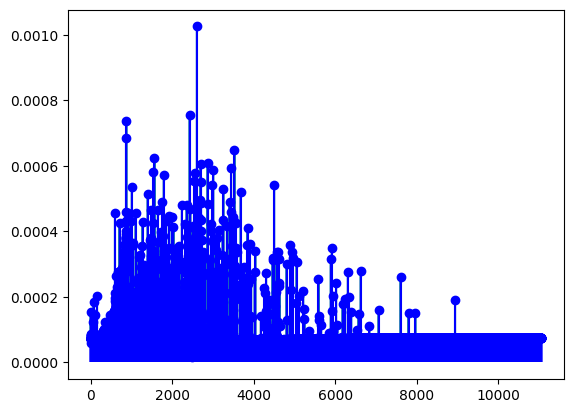

In [17]:
import matplotlib.pyplot as plt
values_to_plot = pred[0, 0, :]  # Extracting the first value along the last axis
plt.plot(values_to_plot)
 
plt.stem(values_to_plot, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.show()

In [6]:
values_to_plot = pred[0, 1, :]  # Extracting the first value along the last axis
plt.plot(values_to_plot)
 
plt.stem(values_to_plot, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1